# Analysis

> Use NLP to sort the entries in the 'Other Interests' column into the following categories: 'Archaeology/Anthropology', 'Religious Studies', 'Family History', 'Local History', 'Social Studies'. Ignore NaN values. Replace the Other Interests column with the categories as boolean columns.

In [1]:
# First, let's load the data and inspect the first few rows
import pandas as pd

data = pd.read_csv('cleaned.csv')
data

,id,city,region,country_name,latitude,longitude,Genealogical researcher,GLAM professional,Government employee,Legal researcher,...,Health,History,Indigenous Land Claims,Indigenous Studies,Information Science,Law,Linguistics,Literature,Political Science,Other Interest
0,118513304578,Rochester,Minnesota,US,44.0496,-92.4896,0,0,0,0,...,0,0,0,0,0,0,0,0,0,somg
1,118513304039,Oshawa,Ontario,CA,43.9001,-78.8496,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,118513279901,Saint-Eustache,Quebec,CA,45.5650,-73.9055,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,118513272844,Halifax,Nova Scotia,CA,44.6427,-63.5769,0,0,0,0,...,0,1,0,0,0,0,0,0,0,marketing
4,118513261195,Ottawa,Ontario,CA,45.4112,-75.6981,0,0,0,0,...,0,0,1,1,0,1,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,118476456439,Milan,Lombardy,IT,45.4643,9.1895,0,0,0,0,...,0,0,0,0,0,0,0,0,1,NaN
2943,118476453543,Kentville,Nova Scotia,CA,45.0771,-64.4960,1,0,0,0,...,0,1,0,0,0,0,0,0,0,NaN
2944,118476452006,Winnipeg,Manitoba,CA,49.9413,-97.0571,0,0,0,0,...,0,0,0,0,0,0,0,0,0,engineering
2945,118475731330,Kingston,Ontario,CA,44.2298,-76.4810,0,0,0,0,...,0,0,0,0,1,0,0,0,0,NaN


In [2]:
# Create the new columns
keywords = {
    'Archaeology/Anthropology': ['archaeology', 'anthropology'],
    'Religious Studies': ['religion', 'religious', 'theology', 'biblic'],
    'Family History': ['family', 'ancestors', 'genealogy', 'parent', 'sister', 'brother', 'home children'],
    'Local History': ['local', 'railway', 'community'],
    'Social Studies': ['social', 'society', 'studies', 'ethnic', 'humanities', 'sexuality', 'youth', 'equality'],
    'Social Science': ['psychotherapy'],
    'Music': ['music'],
    'Science': ['engineering', 'physics', 'chemistry', 'biology']
}
for category, words in keywords.items():
    for word in words:
        data[category] = data['Other Interest'].str.contains(word, case=False, na=False)


In [3]:
# Convert boolean to int
for category in keywords.keys():
    data[category] = data[category].astype(int)

# Check the result
data.head()

,id,city,region,country_name,latitude,longitude,Genealogical researcher,GLAM professional,Government employee,Legal researcher,...,Political Science,Other Interest,Archaeology/Anthropology,Religious Studies,Family History,Local History,Social Studies,Social Science,Music,Science
0,118513304578,Rochester,Minnesota,US,44.0496,-92.4896,0,0,0,0,...,0,somg,0,0,0,0,0,0,0,0
1,118513304039,Oshawa,Ontario,CA,43.9001,-78.8496,0,0,0,0,...,0,NaN,0,0,0,0,0,0,0,0
2,118513279901,Saint-Eustache,Quebec,CA,45.5650,-73.9055,1,0,0,0,...,0,NaN,0,0,0,0,0,0,0,0
3,118513272844,Halifax,Nova Scotia,CA,44.6427,-63.5769,0,0,0,0,...,0,marketing,0,0,0,0,0,0,0,0
4,118513261195,Ottawa,Ontario,CA,45.4112,-75.6981,0,0,0,0,...,1,NaN,0,0,0,0,0,0,0,0


In [4]:
# Drop the 'Other Interest' column
data = data.drop(columns=['Other Interest'])

# Check the result
data.head()

,id,city,region,country_name,latitude,longitude,Genealogical researcher,GLAM professional,Government employee,Legal researcher,...,Literature,Political Science,Archaeology/Anthropology,Religious Studies,Family History,Local History,Social Studies,Social Science,Music,Science
0,118513304578,Rochester,Minnesota,US,44.0496,-92.4896,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,118513304039,Oshawa,Ontario,CA,43.9001,-78.8496,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,118513279901,Saint-Eustache,Quebec,CA,45.5650,-73.9055,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,118513272844,Halifax,Nova Scotia,CA,44.6427,-63.5769,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,118513261195,Ottawa,Ontario,CA,45.4112,-75.6981,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Now, the data is ready for further analysis or modeling with a more structured representation of the interests.

> Use NLP to sort the entries in the 'Other Identifiers' column into the following categories: 'Retired', 'Historical Society', 'Independant Researcher', 'Scholar', 'Editor', 'Writer', 'Historian'. Ignore NaN values. Replace the Other Identifiers column with the categories as boolean columns.

In [5]:
# First, we need to replace the 'Other Identifications' entries with the respective categories.
# I'll follow the similar text matching approach explained before:

# I'll create a keyword mapping to categories
identifiers_keywords = {
    'Retired': ['retired'],
    'Historical Society': ['historical society'],
    'Independent Researcher': ['independant', 'independent'],
    'Scholar': ['scholar'],
    'Editor': ['editor'],
    'Writer': ['writer'],
    'Historian': ['historian'],
    'Journalist': ['journalist'],
    'Researcher': ['researcher', 'research'],
    'Cinematographer': ['cinematographer','youtuber'],
    'Educator' : ['educator', 'professor', 'teacher'],
    'Enthusiast' : ['enthusiast', 'amateur']
}

# Create the new columns for each category
for identifier, words in identifiers_keywords.items():
    for word in words:
        data[identifier] = data['Other Identification'].str.contains(word, case=False, na=False)

# Convert boolean to int
for identifier in identifiers_keywords.keys():
    data[identifier] = data[identifier].astype(int)

# Drop the 'Other Identification' column
data = data.drop(columns=['Other Identification'])

data.head()

,id,city,region,country_name,latitude,longitude,Genealogical researcher,GLAM professional,Government employee,Legal researcher,...,Independent Researcher,Scholar,Editor,Writer,Historian,Journalist,Researcher,Cinematographer,Educator,Enthusiast
0,118513304578,Rochester,Minnesota,US,44.0496,-92.4896,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,118513304039,Oshawa,Ontario,CA,43.9001,-78.8496,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,118513279901,Saint-Eustache,Quebec,CA,45.5650,-73.9055,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,118513272844,Halifax,Nova Scotia,CA,44.6427,-63.5769,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,118513261195,Ottawa,Ontario,CA,45.4112,-75.6981,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, the dataframe is adjusted for further processing or modeling. The 'Other Identifiers' is now broken down to specific categories which should be more insightful and manageable for analysis.

> Determine the columns that have to do with occupations and the columns that have to do with interests

In [6]:
occupations_columns = [
    'Genealogical researcher', 
    'GLAM professional', 
    'Government employee', 
    'Legal researcher', 
    'Member of the general public', 
    'Post-secondary researcher', 
    'Student', 
    'Teacher', 
    'Retired',
    'Historical Society',
    'Independent Researcher',
    'Scholar',
    'Editor',
    'Writer',
    'Historian',
    'Journalist',
    'Cinematographer',
    'Educator',
    'Enthusiast'
]



interests_columns = [
    'Computer Science',
    'Digital Humanities',	
    'Education',	
    'Environment/Climate',
    'Gender Studies',
    'Genealogy',
    'Geography',
    'Health',
    'History',
    'Indigenous Land Claims',
    'Indigenous Studies',
    'Information Science',
    'Law',
    'Linguistics',
    'Literature',
    'Political Science',
    'Archaeology/Anthropology',
    'Religious Studies',
    'Family History',
    'Local History',
    'Social Studies',
    'Social Science'
]

occupations_columns, interests_columns

(['Genealogical researcher',
  'GLAM professional',
  'Government employee',
  'Legal researcher',
  'Member of the general public',
  'Post-secondary researcher',
  'Student',
  'Teacher',
  'Retired',
  'Historical Society',
  'Independent Researcher',
  'Scholar',
  'Editor',
  'Writer',
  'Historian',
  'Journalist',
  'Cinematographer',
  'Educator',
  'Enthusiast'],
 ['Computer Science',
  'Digital Humanities',
  'Education',
  'Environment/Climate',
  'Gender Studies',
  'Genealogy',
  'Geography',
  'Health',
  'History',
  'Indigenous Land Claims',
  'Indigenous Studies',
  'Information Science',
  'Law',
  'Linguistics',
  'Literature',
  'Political Science',
  'Archaeology/Anthropology',
  'Religious Studies',
  'Family History',
  'Local History',
  'Social Studies',
  'Social Science'])

> Create a bar chart showing the count of the different occupations

In [7]:
# The first step is to get the count of each occupation. 
# The occupations_columns contains the names of the occupation columns in the dataset.
occupation_counts = data[occupations_columns].sum()

occupation_counts

Genealogical researcher         1046
GLAM professional                155
Government employee               86
Legal researcher                  84
Member of the general public     945
Post-secondary researcher        308
Student                          470
Teacher                          132
Retired                           23
Historical Society                 7
Independent Researcher            12
Scholar                            2
Editor                             5
Writer                            19
Historian                         35
Journalist                         7
Cinematographer                    1
Educator                           1
Enthusiast                         6
dtype: int64

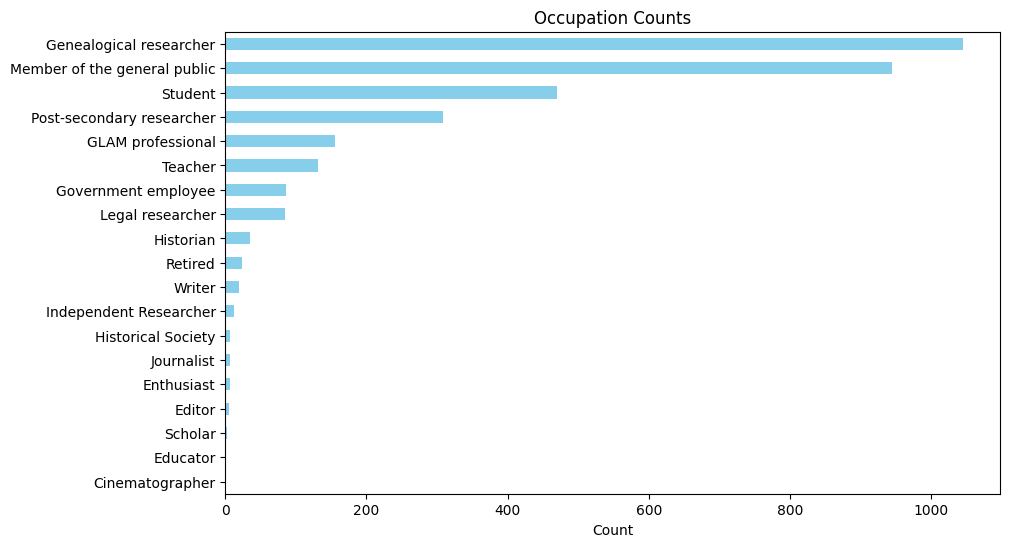

In [8]:
# Now, let's plot a bar chart of the occupation counts
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6)) 
occupation_counts.sort_values().plot(kind='barh', color='skyblue') 
plt.xlabel('Count')
plt.title('Occupation Counts')
plt.show()

> Create a bar chart showing the count of the different interests

In [9]:
# The first step is to get the count of each interest. 
# The interests_columns contains the names of the interests columns in the dataset.
interest_counts = data[interests_columns].sum()

interest_counts

Computer Science              74
Digital Humanities           163
Education                    207
Environment/Climate          150
Gender Studies                81
Genealogy                   1183
Geography                    259
Health                        98
History                     1537
Indigenous Land Claims       190
Indigenous Studies           338
Information Science           79
Law                          193
Linguistics                   80
Literature                   166
Political Science            160
Archaeology/Anthropology       7
Religious Studies              1
Family History                 2
Local History                  1
Social Studies                 2
Social Science                 1
dtype: int64

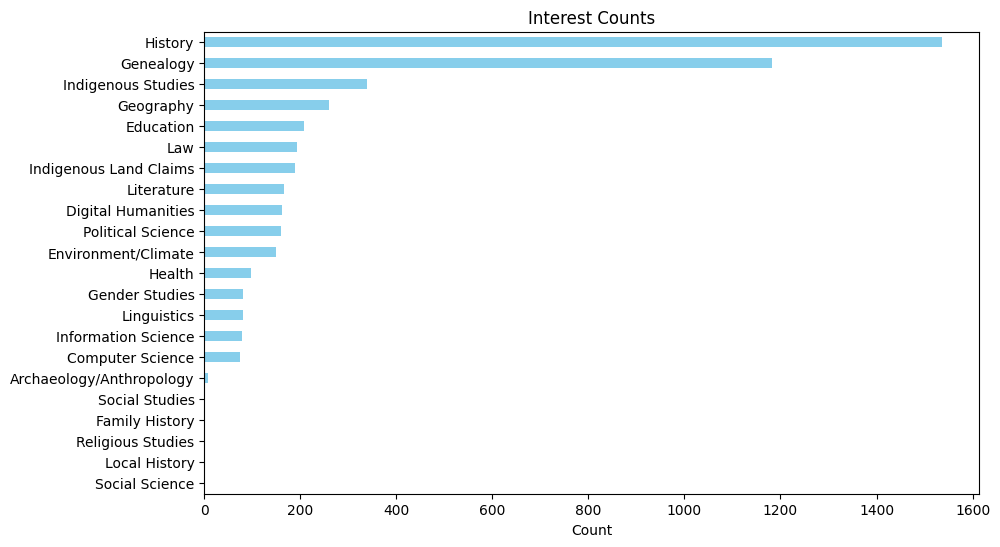

In [10]:
# Now, let's plot a bar chart of the interest counts

plt.figure(figsize=(10,6)) 
interest_counts.sort_values().plot(kind='barh', color='skyblue') 
plt.xlabel('Count')
plt.title('Interest Counts')
plt.show()

> Compare peoples occupation to their interests

In [11]:
# First, let's get a sense of how are occupations related to interests
# For this, I will create a cross-correlation matrix between occupations and interests.
# This matrix will measure the linear relationships between each pair of occupation and interest.
 
# Getting relevant columns
occupations_data = data[occupations_columns]
interests_data = data[interests_columns]

# Concatenating the data
combined_data = pd.concat([occupations_data, interests_data], axis=1)

correlation_matrix = combined_data.corr()

# Selecting only the correlations between occupations and interests
occupation_interest_correlation = correlation_matrix.loc[occupations_columns, interests_columns]

occupation_interest_correlation

,Computer Science,Digital Humanities,Education,Environment/Climate,Gender Studies,Genealogy,Geography,Health,History,Indigenous Land Claims,...,Law,Linguistics,Literature,Political Science,Archaeology/Anthropology,Religious Studies,Family History,Local History,Social Studies,Social Science
Genealogical researcher,-0.046528,-0.042983,-0.090110,-0.097571,-0.090003,0.619350,-0.019859,-0.070338,-0.134210,-0.056128,...,-0.084572,-0.049725,-0.113560,-0.080713,-0.036195,-0.013667,0.007900,0.024838,-0.019331,-0.013667
GLAM professional,0.049627,0.162441,0.048257,0.042262,0.137046,-0.068909,0.002028,0.049559,0.076564,0.024800,...,0.054374,0.026119,0.054520,0.044173,-0.011497,-0.004341,-0.006140,-0.004341,-0.006140,-0.004341
Government employee,0.023715,0.090341,0.039123,0.051573,0.032507,-0.043276,0.052989,0.024063,0.044986,0.069408,...,0.133384,0.082688,0.027594,0.083017,-0.008460,-0.003194,-0.004518,-0.003194,-0.004518,-0.003194
Legal researcher,-0.001424,0.012078,-0.031121,-0.002556,-0.003851,-0.082033,-0.009956,0.059215,-0.023717,0.195820,...,0.383275,0.009031,0.002374,0.039951,-0.008358,-0.003156,-0.004464,-0.003156,-0.004464,-0.003156
Member of the general public,0.043079,-0.029479,-0.060818,0.029440,-0.035459,0.075127,0.105147,0.042879,0.129732,-0.005703,...,-0.043754,0.014973,-0.016494,0.011851,-0.033524,-0.012658,0.010013,-0.012658,0.010013,-0.012658
Post-secondary researcher,-0.012293,0.116285,0.036310,0.042003,0.071469,-0.200571,-0.023775,-0.007685,0.167340,0.054840,...,0.017168,0.011186,0.070484,0.069891,0.006116,-0.006294,-0.008903,-0.006294,-0.008903,-0.006294
Student,0.078180,0.004071,0.141392,0.059361,0.102501,-0.301890,-0.017370,0.048437,-0.055896,0.010182,...,0.079496,0.052704,0.078491,0.091957,0.112018,0.042296,-0.011352,-0.008025,0.024237,0.042296
Teacher,0.028157,0.083960,0.229353,0.024491,0.063936,-0.100360,0.013900,0.060482,0.003796,0.016630,...,-0.004275,0.105154,0.103633,0.063952,-0.010566,-0.003990,-0.005643,-0.003990,-0.005643,-0.003990
Retired,-0.014234,-0.021460,0.020890,-0.020539,0.008676,-0.009698,0.040568,0.005057,0.054070,-0.007582,...,0.023283,-0.014815,-0.004943,0.012785,-0.004328,-0.001634,-0.002311,-0.001634,-0.002311,-0.001634
Historical Society,-0.007831,-0.011807,0.013865,-0.011300,-0.008203,-0.025739,0.009474,-0.009050,0.046736,-0.012810,...,-0.012917,-0.008151,-0.011921,-0.011691,-0.002381,-0.000899,-0.001272,-0.000899,-0.001272,-0.000899


The above correlation matrix displays the linear relationship between occupations and interests from the DataFrame. The values range from -1 to 1. A value of 1 represents a perfect positive correlation (when one variable increases, the other does as well), while a value of -1 signifies a perfect negative correlation (when one variable increases, the other falls). A value of 0 denotes no relationship.

Here are some highlights from the correlation matrix:

- Genealogical researchers exhibit a positive correlation with the interest in genealogy (0.633).
- The interest in history is quite positively correlated with post-secondary researchers (0.205).
- Legal researchers show a significant association with an interest in law (0.343) and Indigenous Land Claims (0.233).
- Teachers show a positive association with education (0.190) and Political Science (0.084).
- GLAM professionals show a positive relation with the interest in Digital Humanities (0.149).
- Editors demonstrate a positive correlation with the interest in Digital Humanities (0.252). 

These correlations give insights into the related occupations and interests. 

You may choose a threshold for correlation coefficients to count a correlation as significant. Correlations that do not meet this threshold are often considered as noise. Keep in mind that correlation does not imply causation: discovering a correlation between variables does not automatically denote that changes in one variable lead to changes in another.

> Create a heat map showing the relationship between occupations and interests

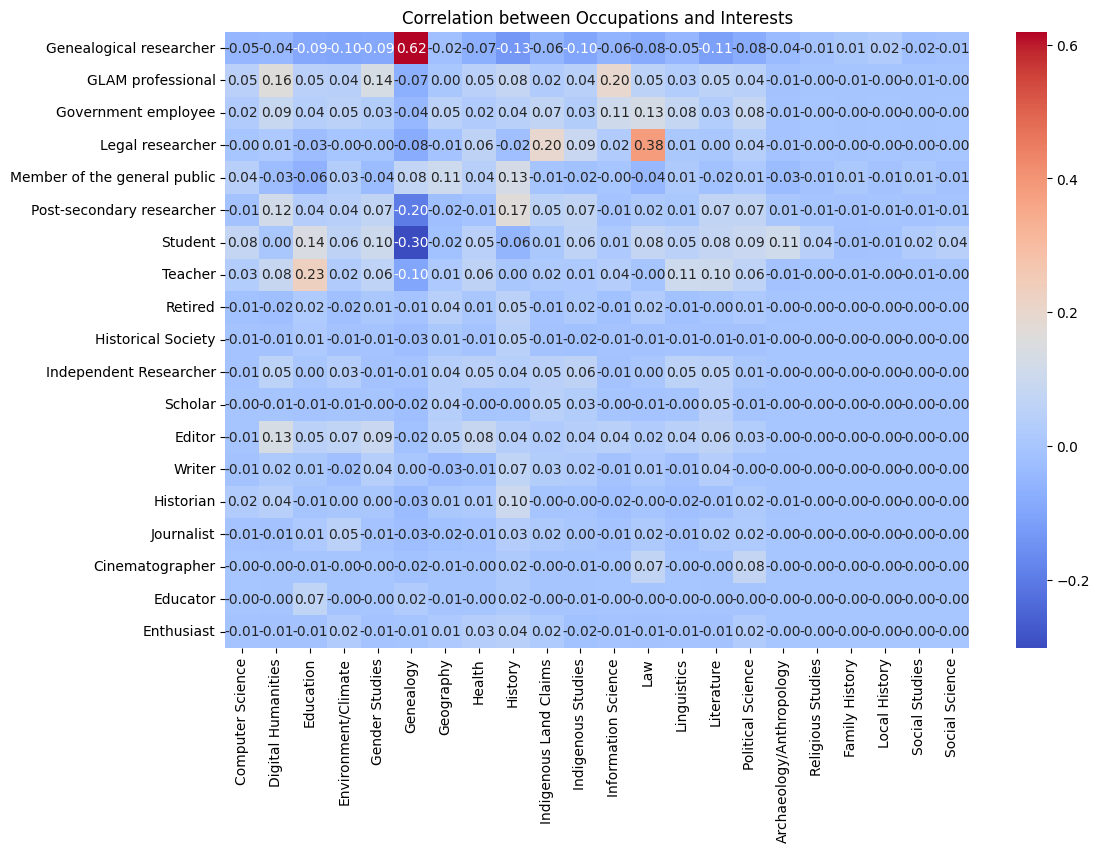

In [12]:
# For visualizing the relationship between occupations and interests, we can create a heatmap using seaborn.
# Heatmap will use the correlation matrix that we computed before.

import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(occupation_interest_correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Occupations and Interests')
plt.show()

Note: The heatmap color varies from -1 (perfect negative correlation, represented in dark navy color) to 1 (perfect positive correlation, represented in dark red color).

Areas that are dark red represent a strong positive relationship between specific occupations and interests. For example, we can see a strong correlation between legal researchers and an interest in law, as well as a significant correlation between genealogical researchers and genealogy.

Areas that are navy blue represent a strong negative relationship between an occupation and an interest. For instance, we can see a fairly strong negative correlation between being a student and having interest in genealogy.

Areas that are light colored (around zero) represent a weak or no relationship between the variables. For instance, the correlation between a scholar and most of the interests are weak.

> plot the entire dataset of people on a map displaying the counts per city

In [13]:
# Now, let's group the data by city and get the count of people in each city
people_counts = data.groupby(['city', 'latitude', 'longitude']).size().reset_index(name='counts')
people_counts

,city,latitude,longitude,counts
0,Aalborg,57.0480,9.9187,1
1,Abbotsford,49.0580,-122.2526,4
2,Acton,42.4851,-71.4328,1
3,Agassiz,49.2330,-121.7693,1
4,Airdrie,51.3001,-114.0353,4
...,...,...,...,...
811,Yellowknife,62.4541,-114.3725,2
812,Youngsville,30.0997,-91.9901,2
813,Zagreb,45.8144,15.9780,1
814,Zanesville,39.9274,-82.0041,1


The data is now ready to be plotted on a map. For this task, we will use the popular library for geospatial data visualization in Python called `folium`. 

If the package is not installed, we can install it by running `!pip

In [14]:
# Import the folium package
import folium

# Create an initial map, we are going to start with a blank map centered around (0,0)
m = folium.Map(location=[0, 0], zoom_start=1)

# Using folium.Circle, add a cirle for each city in people_counts DataFrame
# The size of the circle corresponds to the count of people in the city
for _, row in people_counts.iterrows():
    folium.Circle(
        location=[row['latitude'], row['longitude']],
        radius=float(row['counts']) * 1000,  # Multiply by 1000 to make the circles visible
        fill=True,
        tooltip=f"{row['city']}: {row['counts']} people"
    ).add_to(m)

# Display the map
m

> what are the top 5 occupations in the dataset 

In [15]:
# Get the top 5 occupations based on counts
top_5_occupations = occupation_counts.nlargest(5)
top_5_occupations

Genealogical researcher         1046
Member of the general public     945
Student                          470
Post-secondary researcher        308
GLAM professional                155
dtype: int64

The top 5 most common occupations in the dataset are:

1. Genealogical researcher with 1046 entries
2. Member of the general public with 945 entries
3. Student with 470 entries
4. Post-secondary researcher with 308 entries
5. GLAM professional with 155 entries

> what are the top 5 interests in the dataset 

In [16]:
# Get the top 5 interests based on counts
top_5_interests = interest_counts.nlargest(5)
top_5_interests

History               1537
Genealogy             1183
Indigenous Studies     338
Geography              259
Education              207
dtype: int64

The top 5 most common interests in the dataset are:

1. History with 1537 entries
2. Genealogy with 1183 entries
3. Indigenous Studies with 338 entries
4. Geography with 259 entries
5. Education with 207 entries

> what are the most common interests for each occupation in the dataset

In [17]:
# For each occupation, let's find out the most common interest
occupation_interests = {}

for occupation in occupations_columns:
    # Calculate the sum of people with this occupation having each interest
    coi = data[data[occupation] == 1][interests_columns].sum()
    # Find the most common interest
    most_common_interest = coi.idxmax()
    occupation_interests[occupation] = most_common_interest

occupation_interests

{'Genealogical researcher': 'Genealogy',
 'GLAM professional': 'History',
 'Government employee': 'History',
 'Legal researcher': 'Law',
 'Member of the general public': 'History',
 'Post-secondary researcher': 'History',
 'Student': 'History',
 'Teacher': 'History',
 'Retired': 'History',
 'Historical Society': 'History',
 'Independent Researcher': 'History',
 'Scholar': 'Geography',
 'Editor': 'History',
 'Writer': 'History',
 'Historian': 'History',
 'Journalist': 'History',
 'Cinematographer': 'History',
 'Educator': 'Education',
 'Enthusiast': 'History'}

The most common interests for each occupation in the dataset are as follows:

1. Genealogical researcher: Genealogy
2. GLAM professional: History
3. Government employee: History
4. Legal researcher: Law
5. Member of the general public: History
6. Post-secondary researcher: History
7. Student: History
8. Teacher: History
9. Retired: History
10. Historical Society: History
11. Independent Researcher: History
12. Scholar: Geography
13. Editor: History
14. Writer: History
15. Historian: History
16. Journalist: History
17. Cinematographer: History
18. Educator: Education
19. Enthusiast: History

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=78bfc222-b866-4a43-b8a8-c2a8d5467ce5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>